In [40]:
import pandas as pd
import os
import sqlite3
import openmeteo_requests
import requests_cache
from retry_requests import retry
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# Konfigurationsparameter
CONFIG = {
    "DB_PATH": "../nextbike_data_old.db",
    "WEATHER_API_URL": "https://archive-api.open-meteo.com/v1/archive",
    "CSV_BIKES": "city_summaries.csv",
    "CSV_WEATHER": "weather_data.csv",
    "LAT": 49.0094,
    "LON": 8.4044,
    "START_DATE": "2025-09-01",
    "END_DATE": "2025-10-31",
    "CITY_NAME": "Karlsruhe"
}

# Feiertage/Ferien für die day_type Klassifizierung
HOLIDAYS = [
    '2025-01-01', '2025-01-06', '2025-04-18', '2025-04-21', 
    '2025-05-01', '2025-05-29', '2025-06-09', '2025-06-19', 
    '2025-10-03', '2025-11-01', '2025-12-25', '2025-12-26'
]

In [41]:
def get_nextbike_data(config):
    """Extrahiert die stündlichen Zusammenfassungsdaten aus der Nextbike-SQL-Datenbank"""
    # Falls CSV existiert, direkt laden
    if os.path.exists(config["CSV_BIKES"]):
        print(f"{config['CSV_BIKES']} gefunden. Lade lokale Daten.")
        return pd.read_csv(config["CSV_BIKES"])
    
    # Andernfalls SQL-Datenbank abfragen
    print("Keine CSV gefunden. Starte SQL-Extraktion...")
    try:
        conn = sqlite3.connect(config["DB_PATH"])
        
        # SQL-Abfrage zur Extraktion der stündlichen Zusammenfassungsdaten
        query = """
        SELECT 
            date(timestamp) as date, 
            strftime('%H', timestamp) as hour,
            AVG(available_bikes) as available_bikes, 
            AVG(booked_bikes) as booked_bikes,
            AVG(total_bikes) as total_bikes
        FROM city_summaries
        GROUP BY date, hour
        """
        # Daten aus der SQL-Datenbank in ein DataFrame laden
        df = pd.read_sql_query(query, conn)
        conn.close()
        
        # DataFrame als CSV speichern
        df.to_csv(config["CSV_BIKES"], index=False)
        print("Die Nextbike-Datenbank wurde erfolgreich extrahiert. "
                f"Die Daten wurden in {config['CSV_BIKES']} gespeichert.")
        return df
        
    except sqlite3.Error as e:
        print(f"✗ SQL-Datenbank Fehler: {e}")
        return None


def get_weather_data(config):
    """Ruft Wetterdaten von der Open-Meteo API ab und speichert sie lokal als CSV."""
    # Falls CSV existiert, direkt laden
    if os.path.exists(config["CSV_WEATHER"]):
        print(f"{config['CSV_WEATHER']} gefunden. Lade lokale Daten.")
        return pd.read_csv(config["CSV_WEATHER"])
    
    # Andernfalls API abfragen
    print("Keine CSV gefunden. Rufe Wetterdaten von Open-Meteo ab...")
    try:
        cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
        retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
        openmeteo = openmeteo_requests.Client(session=retry_session)

        # API-Parameter definieren
        params = {
            "latitude": config["LAT"], "longitude": config["LON"],
            "start_date": config["START_DATE"], "end_date": config["END_DATE"],
            "hourly": ["temperature_2m", "rain", "wind_speed_10m", "relative_humidity_2m", "cloud_cover"],
            "timezone": "Europe/Berlin",
        }
        responses = openmeteo.weather_api(config["WEATHER_API_URL"], params=params)
        
        # Erste Antwort extrahieren
        res = responses[0]
        hourly = res.Hourly()

        # Daten in ein Dictionary umwandeln
        data = {"timestamp": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=hourly.Interval()), inclusive="left"
        )}
        # Wettervariablen hinzufügen
        for i, var in enumerate(params["hourly"]):
            data[var] = hourly.Variables(i).ValuesAsNumpy()

        # DataFrame erstellen und als CSV speichern
        df_weather = pd.DataFrame(data=data)
        df_weather.to_csv(config["CSV_WEATHER"], index=False)
        print("Die Wetterdaten wurden erfolgreich extrahiert. "
                f"Die Daten wurden in {config['CSV_WEATHER']} gespeichert.")
        return df_weather
    
    except Exception as e:
        print(f"✗ Wetter-API Fehler: {e}")
        return None

In [42]:
# 1. Daten laden
print ("Starte Setup...")
bikes_df = get_nextbike_data(CONFIG)
weather_df = get_weather_data(CONFIG)

# 2. Vorbereitung zum Mergen (timestamps angleichen)
bikes_df['timestamp'] = pd.to_datetime(bikes_df['date'] + ' ' + bikes_df['hour'].astype(str).str.zfill(2) + ':00:00').dt.tz_localize('UTC')
weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'])

# 3. Sortieren und Mergen
merged_df = pd.merge_asof(
    bikes_df.sort_values('timestamp'),
    weather_df.sort_values('timestamp'),
    on='timestamp',
    direction='nearest'
)

# 4. day_type Spalte hinzufügen
def get_day_type(ts):
    """Bestimmt den Tagestyp basierend auf Datum."""
    date_str = ts.strftime('%Y-%m-%d')
    if date_str in HOLIDAYS:
        return 'Ferien'
    elif ts.weekday() >= 5:
        return 'Wochenende'
    else:
        return 'Wochentag'

merged_df['day_type'] = merged_df['timestamp'].apply(get_day_type)
day_types = ['Wochentag', 'Wochenende', 'Ferien']
colors = {'Wochentag': '#1f77b4', 'Wochenende': '#ff7f0e', 'Ferien': '#d62728'}

print("Setup abgeschlossen. 'merged_df' steht für Analysen bereit.")

Starte Setup...
city_summaries.csv gefunden. Lade lokale Daten.
weather_data.csv gefunden. Lade lokale Daten.
Setup abgeschlossen. 'merged_df' steht für Analysen bereit.


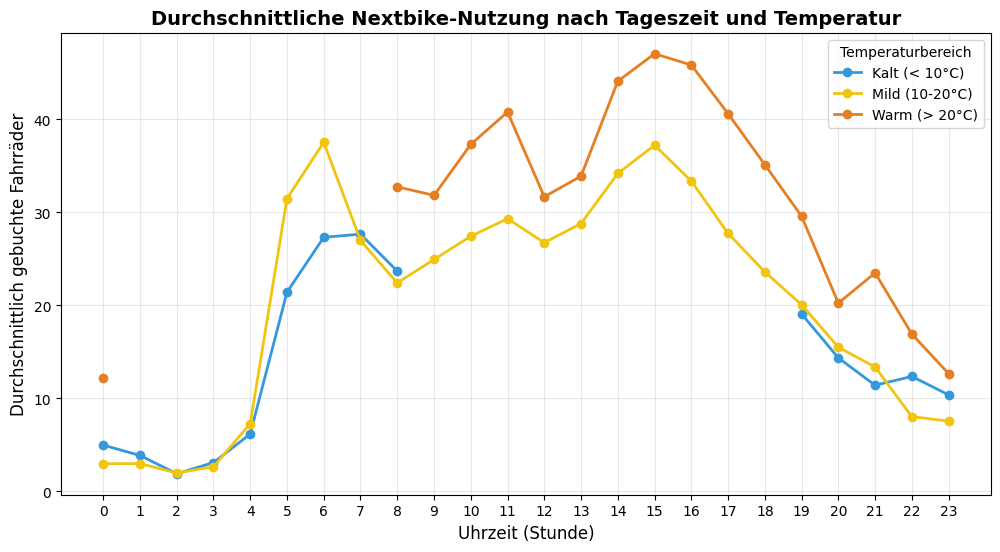

In [43]:
# ANALYSE 1: 24h-Profile nach Temperatur-Clustern
plt.figure(figsize=(12, 6))

# 1. Temperatur-Cluster definieren
def cluster_temp(t):
    if t < 10: return 'Kalt (< 10°C)'
    if t <= 20: return 'Mild (10-20°C)'
    return 'Warm (> 20°C)'

merged_df['temp_cluster'] = merged_df['temperature_2m'].apply(cluster_temp)
merged_df['hour_only'] = merged_df['timestamp'].dt.hour

# 2. Gruppieren nach Stunde und Cluster
hourly_profiles = merged_df.groupby(['hour_only', 'temp_cluster'])['booked_bikes'].mean().unstack()

# 3. Plotten
colors_temp = {'Kalt (< 10°C)': '#3498db', 'Mild (10-20°C)': '#f1c40f', 'Warm (> 20°C)': '#e67e22'}
for cluster in hourly_profiles.columns:
    plt.plot(hourly_profiles.index, hourly_profiles[cluster], 
             label=cluster, marker='o', linewidth=2, color=colors_temp.get(cluster))

plt.title('Durchschnittliche Nextbike-Nutzung nach Tageszeit und Temperatur', fontsize=14, fontweight='bold')
plt.xlabel('Uhrzeit (Stunde)', fontsize=12)
plt.ylabel('Durchschnittlich gebuchte Fahrräder', fontsize=12)
plt.xticks(range(0, 24))
plt.legend(title='Temperaturbereich')
plt.grid(True, alpha=0.3)
plt.show()

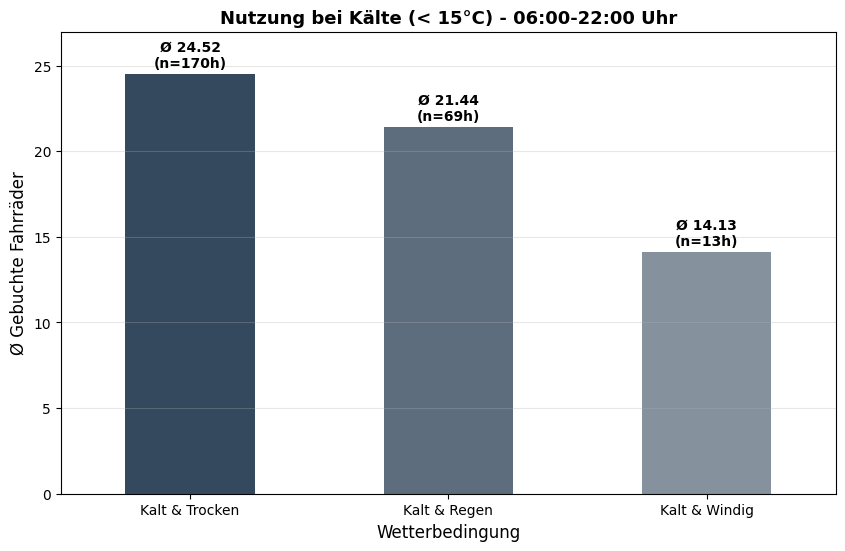

In [44]:
# ANALYSE 2: Einfluss von Wind und Regen bei Kälte (< 10°C)
active_cold_hours = merged_df[
    (merged_df['temperature_2m'] < 15) & 
    (merged_df['timestamp'].dt.hour >= 6) & 
    (merged_df['timestamp'].dt.hour <= 22)
].copy()

# Kategorien definieren
def categorize_cold_weather(row):
    if row['rain'] > 0.1: return 'Kalt & Regen'
    if row['wind_speed_10m'] > 20: return 'Kalt & Windig'
    return 'Kalt & Trocken'

active_cold_hours['condition'] = active_cold_hours.apply(categorize_cold_weather, axis=1)

# Statistiken berechnen: Mittelwert UND Anzahl der Stunden
stats = active_cold_hours.groupby('condition')['booked_bikes'].agg(['mean', 'count']).sort_values('mean', ascending=False)

# Plotten
plt.figure(figsize=(10, 6))
ax = stats['mean'].plot(kind='bar', color=['#34495e', '#5d6d7e', '#85929e'])

plt.title('Nutzung bei Kälte (< 15°C) - 06:00-22:00 Uhr', fontsize=13, fontweight='bold')
plt.ylabel('Ø Gebuchte Fahrräder', fontsize=12)
plt.xlabel('Wetterbedingung', fontsize=12)
plt.xticks(rotation=0)

# Beschriftung mit Mittelwert UND Anzahl der Datenpunkte (n)
for i, (idx, row) in enumerate(stats.iterrows()):
    plt.text(i, row['mean'] + 0.2, f"Ø {row['mean']:.2f}\n(n={int(row['count'])}h)", 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.ylim(0, stats['mean'].max() * 1.1)
plt.grid(axis='y', alpha=0.3)
plt.show()

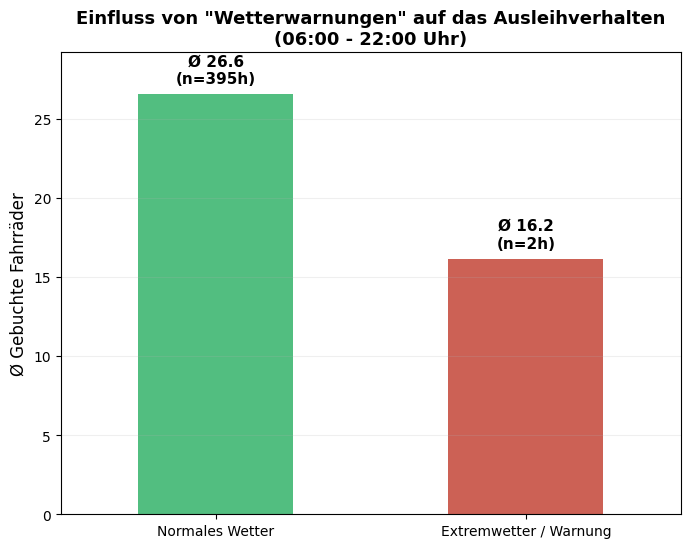

In [45]:
# ANALYSE 3: Einfluss von extremen Wetterereignissen (Warnungs-Proxy)

# 1. Definition der Extremereignisse (Schwellenwerte für "Warnungen")
merged_df['is_extreme'] = (
    (merged_df['rain'] > 3) |                # Starkregen (> 3mm/h)
    (merged_df['wind_speed_10m'] > 35) |       # Starker Wind / Sturm (> 35km/h)
    ((merged_df['temperature_2m'] < 1) & (merged_df['rain'] > 0)) # Glatteis-Gefahr
)

# 2. Vergleich: Durchschnittliche Nutzung bei Extremwetter vs. Normal
core_hours = merged_df[(merged_df['timestamp'].dt.hour >= 6) & (merged_df['timestamp'].dt.hour <= 22)].copy()

# Statistik berechnen: Mittelwert UND Anzahl n
extreme_stats = core_hours.groupby('is_extreme')['booked_bikes'].agg(['mean', 'count'])
extreme_stats.index = ['Normales Wetter', 'Extremwetter / Warnung']

# 3. Plotten
plt.figure(figsize=(8, 6))
ax = extreme_stats['mean'].plot(kind='bar', color=['#27ae60', '#c0392b'], alpha=0.8)

plt.title('Einfluss von "Wetterwarnungen" auf das Ausleihverhalten\n(06:00 - 22:00 Uhr)', fontsize=13, fontweight='bold')
plt.ylabel('Ø Gebuchte Fahrräder', fontsize=12)
plt.xticks(rotation=0)

# Beschriftung der Säulen mit Ø und Fallzahl n
for i, (idx, row) in enumerate(extreme_stats.iterrows()):
    plt.text(i, row['mean'] + 0.5, f"Ø {row['mean']:.1f}\n(n={int(row['count'])}h)", 
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.ylim(0, extreme_stats['mean'].max() * 1.1) # Etwas mehr Platz nach oben für die n-Beschriftung
plt.grid(axis='y', alpha=0.2)
plt.show()

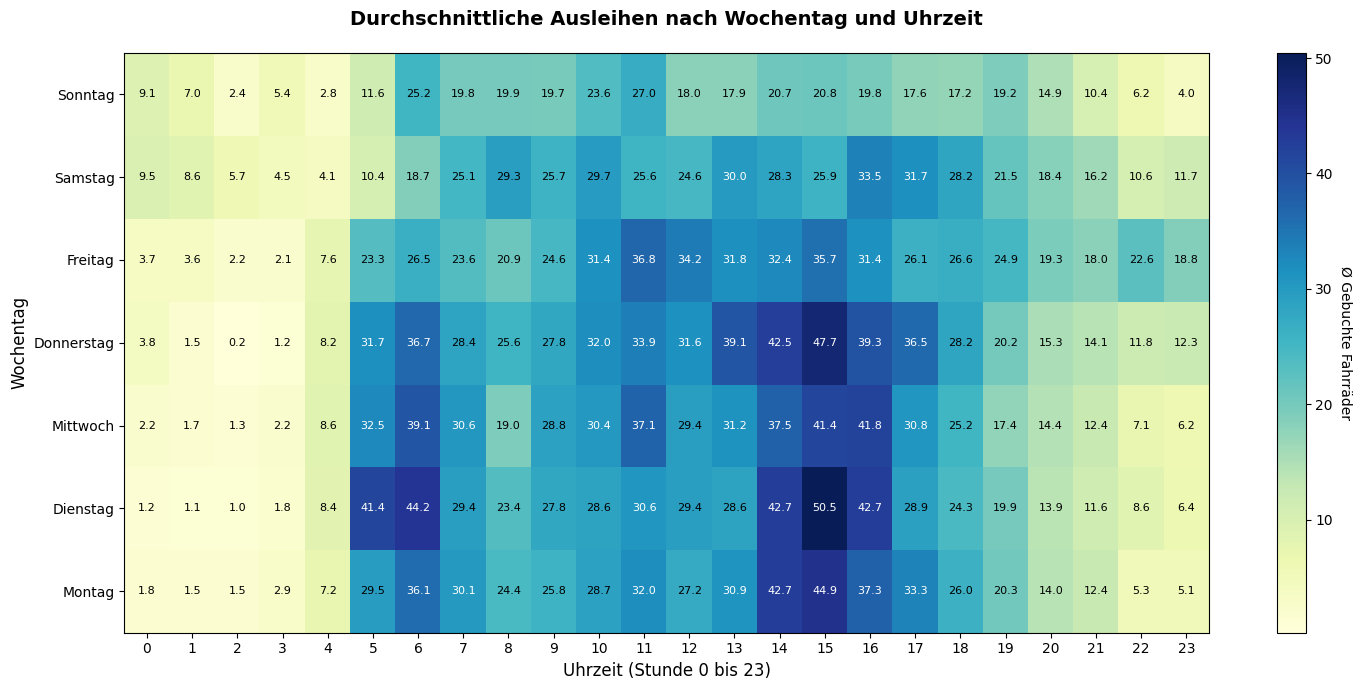

In [46]:
# ANALYSE 4: Heatmap mit Matplotlib (X=Uhrzeit, Y=Wochentag)

# 1. Daten vorbereiten
heatmap_data = merged_df.copy()
heatmap_data['weekday_num'] = heatmap_data['timestamp'].dt.weekday # 0=Montag, 6=Sonntag
heatmap_data['hour'] = heatmap_data['timestamp'].dt.hour

# Pivot-Tabelle: Index = Wochentage (Y-Achse), Spalten = Stunden (X-Achse)
pivot_df = heatmap_data.groupby(['weekday_num', 'hour'])['booked_bikes'].mean().unstack()

# Fehlende Werte mit 0 füllen
pivot_df = pivot_df.fillna(0)

# 2. Plotten mit Matplotlib
fig, ax = plt.subplots(figsize=(15, 7))

# origin='lower' sorgt dafür, dass Index 0 (Montag) unten ist und Index 6 (Sonntag) oben
im = ax.imshow(pivot_df, cmap='YlGnBu', aspect='auto', origin='lower')

# Achsenbeschriftungen
days = ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag']
ax.set_yticks(np.arange(len(days)))
ax.set_yticklabels(days)

ax.set_xticks(np.arange(0, 24, 1))
ax.set_xticklabels(np.arange(0, 24, 1))

# Labels
plt.title('Durchschnittliche Ausleihen nach Wochentag und Uhrzeit', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Uhrzeit (Stunde 0 bis 23)', fontsize=12)
plt.ylabel('Wochentag', fontsize=12)

# Farbbalken (Colorbar)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Ø Gebuchte Fahrräder', rotation=-90, va="bottom")

# Werte in die Zellen schreiben
for y in range(len(days)):
    for x in range(24):
        val = pivot_df.iloc[y, x]
        # Textfarbe an Hintergrund anpassen (heller Text auf dunklem Grund)
        text_color = "white" if val > pivot_df.values.max()/1.7 else "black"
        ax.text(x, y, f"{val:.1f}", ha="center", va="center", color=text_color, fontsize=8)

plt.tight_layout()
plt.show()

/tmp/ipykernel_3188/3572509300.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rain_stats = active_df.groupby('rain_cat')['booked_bikes'].agg(['mean', 'count'])
/tmp/ipykernel_3188/3572509300.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wind_stats = active_df.groupby('wind_cat')['booked_bikes'].agg(['mean', 'count'])


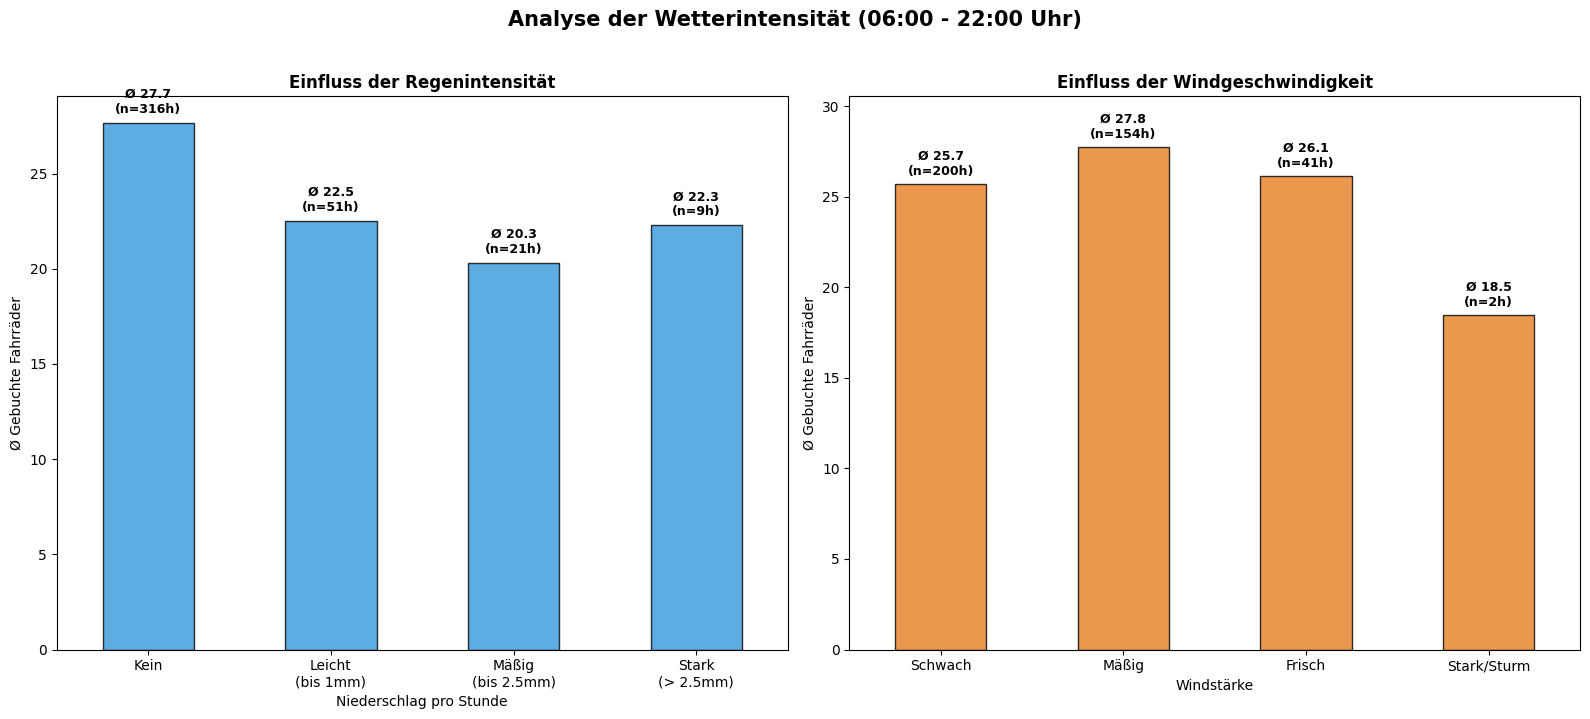

In [47]:
# ANALYSE 5 & 6: Detaillierte Wetterfaktoren (06:00 - 22:00 Uhr)

# 1. Daten filtern
active_df = merged_df[(merged_df['timestamp'].dt.hour >= 6) & (merged_df['timestamp'].dt.hour <= 22)].copy()

# 2. Kategorien erstellen
# Regen in mm/h
active_df['rain_cat'] = pd.cut(active_df['rain'], 
                               bins=[-0.1, 0.1, 1.0, 2.5, np.inf], 
                               labels=['Kein', 'Leicht\n(bis 1mm)', 'Mäßig\n(bis 2.5mm)', 'Stark\n(> 2.5mm)'])

# Wind in km/h
active_df['wind_cat'] = pd.cut(active_df['wind_speed_10m'], 
                               bins=[-0.1, 10, 20, 30, np.inf], 
                               labels=['Schwach', 'Mäßig', 'Frisch', 'Stark/Sturm'])

# 3. Plotten (Subplots)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Plot A: Regenmenge
rain_stats = active_df.groupby('rain_cat')['booked_bikes'].agg(['mean', 'count'])
rain_stats['mean'].plot(kind='bar', ax=ax1, color='#3498db', alpha=0.8, edgecolor='black')
ax1.set_title('Einfluss der Regenintensität', fontsize=12, fontweight='bold')
ax1.set_ylabel('Ø Gebuchte Fahrräder')
ax1.set_xlabel('Niederschlag pro Stunde')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
plt.ylim(0, rain_stats['mean'].max() * 1.1)

for i, (idx, row) in enumerate(rain_stats.iterrows()):
    ax1.text(i, row['mean'] + 0.5, f"Ø {row['mean']:.1f}\n(n={int(row['count'])}h)", ha='center', fontweight='bold', fontsize=9)

# Plot B: Windgeschwindigkeit
wind_stats = active_df.groupby('wind_cat')['booked_bikes'].agg(['mean', 'count'])
wind_stats['mean'].plot(kind='bar', ax=ax2, color='#e67e22', alpha=0.8, edgecolor='black')
ax2.set_title('Einfluss der Windgeschwindigkeit', fontsize=12, fontweight='bold')
ax2.set_ylabel('Ø Gebuchte Fahrräder')
ax2.set_xlabel('Windstärke')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
plt.ylim(0, wind_stats['mean'].max() * 1.1)

for i, (idx, row) in enumerate(wind_stats.iterrows()):
    ax2.text(i, row['mean'] + 0.5, f"Ø {row['mean']:.1f}\n(n={int(row['count'])}h)", ha='center', fontweight='bold', fontsize=9)

plt.suptitle('Analyse der Wetterintensität (06:00 - 22:00 Uhr)', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [48]:
# statistische Zusammenfassung und Erkenntnisse
print("="*70)
print("STATISTISCHE ZUSAMMENFASSUNG")
print("="*70)

for day_type in day_types:
    data = merged_df[merged_df['day_type'] == day_type]
    print(f"\n{day_type.upper()}:")
    print(f"  Datenpunkte: {len(data)}")
    print(f"  Gebuchte Fahrräder - Mittelwert: {data['booked_bikes'].mean():.2f}, "
          f"Min: {data['booked_bikes'].min():.2f}, Max: {data['booked_bikes'].max():.2f}")
    print(f"  Temperatur - Mittelwert: {data['temperature_2m'].mean():.2f}°C, "
          f"Bereich: {data['temperature_2m'].min():.2f}°C bis {data['temperature_2m'].max():.2f}°C")
    print(f"  Regnerische Stunden: {(data['rain'] > 0.5).sum()} ({(data['rain'] > 0.5).sum()/len(data)*100:.1f}%)")

# Zusätzliche Metriken
print("\n" + "="*70)
print("ZUSÄTZLICHE METRIKEN")
print("="*70)

# Gesamte Anzahl Ausleihen pro Tag (Durchschnitt)
daily_totals = merged_df.groupby(merged_df['timestamp'].dt.date)['booked_bikes'].sum()
avg_daily_rentals = daily_totals.mean()
print(f"Gesamte Ausleihen pro Tag (Durchschnitt): {avg_daily_rentals:.2f}")

# Durchschnittsausleihen pro Stunde
avg_hourly_rentals = merged_df['booked_bikes'].mean()
print(f"Durchschnittliche Ausleihen pro Stunde: {avg_hourly_rentals:.2f}")

# Hauptpendeltage (Tage mit höchster Aktivität)
day_of_week_avg = merged_df.groupby(merged_df['timestamp'].dt.day_name())['booked_bikes'].mean().sort_values(ascending=False)
print(f"Hauptpendeltage (nach durchschnittlicher Aktivität):")
for day, avg in day_of_week_avg.head(3).items():
    print(f"  {day}: {avg:.2f} Ausleihen/Stunde")

# Fahrten pro Stunde vs. Temperatur (Korrelationsanalyse)
temp_corr = merged_df['temperature_2m'].corr(merged_df['booked_bikes'])
print(f"Korrelation zwischen Temperatur und Ausleihen pro Stunde: {temp_corr:.3f}")

print("\n" + "="*70)
print("KORRELATIONSKOEFFIZIENTEN")
print("="*70)
for day_type in day_types:
    print(f"\n{day_type.upper()}:")
    if day_type in correlations:
        for factor, corr in correlations[day_type].items():
            strength = "Stark" if abs(corr) > 0.6 else "Moderat" if abs(corr) > 0.3 else "Schwach"
            direction = "Positiv" if corr > 0 else "Negativ"
            print(f"  {factor:12} → {corr:7.3f} ({direction:8} - {strength})")
    else:
        print("  Keine Korrelationen verfügbar (unzureichende Daten)")

print("\n" + "="*70)
print("WICHTIGSTE ERKENNTNISSE")
print("="*70)

# Find strongest correlations
all_corrs = []
for day_type, factors in correlations.items():
    for factor, corr in factors.items():
        all_corrs.append((day_type, factor, corr))

all_corrs.sort(key=lambda x: abs(x[2]), reverse=True)
print("\nStärkste Korrelationen (nach absolutem Wert):")
for day_type, factor, corr in all_corrs[:5]:
    print(f"  {factor:12} bei {day_type:10} → {corr:7.3f}")

# Temperature impact
print("\nTemperatureinfluss:")
for temp_range in ['<10°C', '10-15°C', '15-20°C', '>20°C']:
    avg = merged_df[merged_df['temp_range'] == temp_range]['booked_bikes'].mean()
    count = len(merged_df[merged_df['temp_range'] == temp_range])
    print(f"  {temp_range:10} → {avg:6.2f} Fahrräder im Durchschnitt ({count} Beobachtungen)")

# Rain impact
print("\nRegeneinfluss:")
dry_avg = merged_df[merged_df['rain_condition'] == 'Trocken']['booked_bikes'].mean()
rainy_avg = merged_df[merged_df['rain_condition'] == 'Regnerisch']['booked_bikes'].mean()
print(f"  Trockene Bedingungen  → {dry_avg:6.2f} Fahrräder im Durchschnitt")
print(f"  Regnerische Bedingungen → {rainy_avg:6.2f} Fahrräder im Durchschnitt")
print(f"  Unterschied          → {dry_avg - rainy_avg:6.2f} Fahrräder ({(dry_avg - rainy_avg)/rainy_avg*100:.1f}% mehr)")

STATISTISCHE ZUSAMMENFASSUNG

WOCHENTAG:
  Datenpunkte: 393
  Gebuchte Fahrräder - Mittelwert: 22.79, Min: 0.08, Max: 61.83
  Temperatur - Mittelwert: 13.13°C, Bereich: 4.50°C bis 27.85°C
  Regnerische Stunden: 43 (10.9%)

WOCHENENDE:
  Datenpunkte: 148
  Gebuchte Fahrräder - Mittelwert: 17.22, Min: 1.00, Max: 57.50
  Temperatur - Mittelwert: 14.79°C, Bereich: 7.80°C bis 30.95°C
  Regnerische Stunden: 17 (11.5%)

FERIEN:
  Datenpunkte: 24
  Gebuchte Fahrräder - Mittelwert: 13.73, Min: 2.25, Max: 30.08
  Temperatur - Mittelwert: 9.73°C, Bereich: 6.10°C bis 13.40°C
  Regnerische Stunden: 0 (0.0%)

ZUSÄTZLICHE METRIKEN
Gesamte Ausleihen pro Tag (Durchschnitt): 473.33
Durchschnittliche Ausleihen pro Stunde: 20.94
Hauptpendeltage (nach durchschnittlicher Aktivität):
  Thursday: 23.73 Ausleihen/Stunde
  Tuesday: 22.77 Ausleihen/Stunde
  Friday: 22.01 Ausleihen/Stunde
Korrelation zwischen Temperatur und Ausleihen pro Stunde: 0.460

KORRELATIONSKOEFFIZIENTEN

WOCHENTAG:


NameError: name 'correlations' is not defined